# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Phase 2 Milestone 2</p>

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

# Table of Contents

1. Introduction
2. Import Libraries
3. Data Loading
4. Exploratory Data Analysis
5. Data Preprocessing
6. Model Definition
7. Model Training
8. Model Evaluation
9. Model Inference
10. Conclusion


# 1. Introduction

name : Reza Ismail Hasan

Class : HCK - 01


### Background 

Kebutuhan daging sapi terus melambung tinggi dari tahun ke tahun sejalan dengan pertambahan jumlah penduduk Indonesia yang semakin tinggi pula. Selain itu, permintaan daging sapi lokal akan melonjak naik terutama pada hari-hari besar seperti saat Ramadhan dan hari raya Idul Fitri. Namun, hal ini berbanding terbalik dengan volume daging sapi lokal yang dapat diproduksi. Hal ini mengakibatkan tingginya harga jual daging sapi di pasar dan mengakibatkan beberapa oknum pedagang melakukan kecurangan untuk memperoleh keuntungan, salah satunya yaitu menjual daging yang tidak layak dikonsumsi seperti daging busuk. Selama ini untuk membedakan daging segar dan daging yang tidak layak dikonsumsi dapat dilihat dari warna, kadar air, bau daging. Namun, cara tersebut belum tentu akurat. Untuk mengatasi hal tersebut, saya membuat model berbasis Convotional Neural Network untuk mengetahui kesegaran daging. 

Pada kasus ini klasifikasi dibagi menjadi 3 tingkat kesegaran yaitu :
Fresh, Half-Fresh, Spoiled

### Dataset Source
https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset

# 2. Import Libraries

In [2]:
import numpy as np
import PIL
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling2D, Convolution2D,MaxPooling2D,GlobalAveragePooling2D, Flatten
from tensorflow.keras import layers
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.xception import Xception

import pickle
import warnings
warnings.simplefilter('ignore')

np.random.seed(99)
tf.random.set_seed(50)

2022-10-17 16:32:14.470955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Data Loading

In [3]:
base_path = '/Users/rezaismail/Hacktiv8/Phase 2/Assignment/M2/Meat Freshness.v1-new-dataset.multiclass/output'
train_folder= base_path+'/train'
val_folder= base_path+'/val'

### Jumlah data di tiap folder train dan folder validation

In [4]:
print("Training : \n")
print(len(os.listdir(base_path+"/train/FRESH")))
print(len(os.listdir(base_path+"/train/HALF-FRESH")))
print(len(os.listdir(base_path+"/train/SPOILED")))
print("Validation : \n")

print(len(os.listdir(base_path+"/val/FRESH")))
print(len(os.listdir(base_path+"/val/HALF-FRESH")))
print(len(os.listdir(base_path+"/val/SPOILED")))

Training : 

672
627
507
Validation : 

178
159
114


# Exploratory Data Analysis

### Fresh Meat

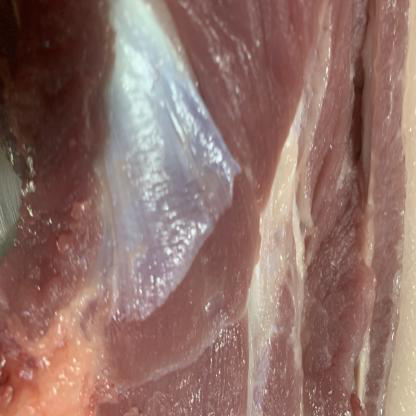

In [7]:
fresh = list(data_dir.glob('FRESH/*'))
PIL.Image.open(str(fresh[0]))

### Half Fresh

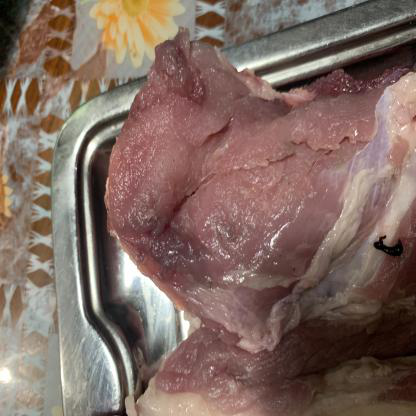

In [24]:
half_fresh = list(data_dir.glob('HALF-FRESH/*'))
PIL.Image.open(str(half_fresh[0]))

### Spoiled

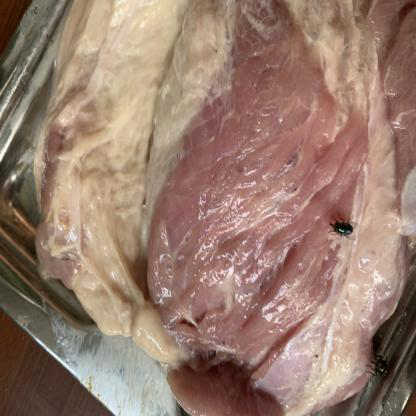

In [26]:
spoiled = list(data_dir.glob('SPOILED/*'))
PIL.Image.open(str(spoiled[0]))

# 5. Data Preprocessing


Mendefinisikan ukuran gambar dan batch size untuk data preprocessing

In [5]:
IMG_WIDTH=150
IMG_HEIGHT=150
batch_size=32

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 1806 files belonging to 3 classes.


2022-10-17 16:33:31.174478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 451 files belonging to 3 classes.


In [8]:
class_names = train_dataset.class_names
print(class_names)

['FRESH', 'HALF-FRESH', 'SPOILED']


In [12]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


### Configure Dataset Performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Melakukan autotune data train dan validation untuk memastikan dataset tidak terjadi bottleneck saat training model.

### Standardize the data


In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99288476


Melakukan standarisasi data dari channel RGB [0,255] menjadi [0,1]

# 6. Model Definition

In [13]:
num_classes = 3

model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Mendefinisikan model dengan dengan 3 convotional blocks masing-masing menggunakan max pool layer. Kemudian terhubung dengan layer dense dengan 128 unit neuron menggunakan activation fungtion relu. 

### Compile The Model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

Menampilkan semua layer dari model yang sudah dibuat dengan method summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

Pada model ini tardapat 3,989,027 paramater yang akan dilakukan training

# 7. Model Training

Melakukan training model dengan epoch = 10

In [43]:
epochs=10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/10
226/226 [==============================] - 59s 258ms/step - loss: 7.3097 - accuracy: 0.6539 - val_loss: 0.7821 - val_accuracy: 0.7162
Epoch 2/10
226/226 [==============================] - 62s 275ms/step - loss: 0.4246 - accuracy: 0.8295 - val_loss: 0.5161 - val_accuracy: 0.8470
Epoch 3/10
226/226 [==============================] - 63s 277ms/step - loss: 0.2561 - accuracy: 0.9003 - val_loss: 0.4862 - val_accuracy: 0.8581
Epoch 4/10
226/226 [==============================] - 61s 268ms/step - loss: 0.2032 - accuracy: 0.9269 - val_loss: 0.5591 - val_accuracy: 0.8248
Epoch 5/10
226/226 [==============================] - 57s 251ms/step - loss: 0.2456 - accuracy: 0.9131 - val_loss: 0.7380 - val_accuracy: 0.7827
Epoch 6/10
226/226 [==============================] - 61s 268ms/step - loss: 0.1388 - accuracy: 0.9480 - val_loss: 0.7487 - val_accuracy: 0.8315
Epoch 7/10
226/226 [==============================] - 53s 232ms/step - loss: 0.1092 - accuracy: 0.9646 - val_loss: 0.7843 - val_ac

# Model Evaluation

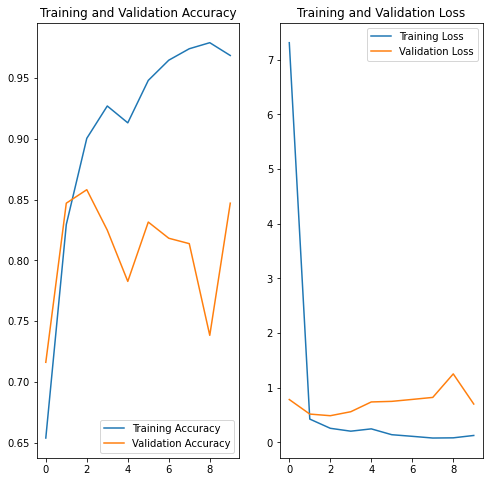

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Hasil evaluasi pada model diatas terlihat bahwa akurasi training semakin membesar dengan nilai akurasi validation naik turun secara beragam antara 0,70 - 0,85 (gradient exploding).
Dapat disimpulkan bahwa model tersebut masih mengalami overfitting.

## Model Improvement

Dalam peningkatan kualitas model yang overfitting, saya lakukan preprocessing data dengan image augmentation

### Image Data Preprocessing

In [16]:
"""All images will be scaled to 1./255 to obtain 0-1 normalized image.Also image augmentation is used."""
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,rotation_range = 40,
                                                                 width_shift_range = 0.2,height_shift_range = 0.2,
                                                                 shear_range = 0.2,zoom_range = 0.2,
                                                                 horizontal_flip = True,vertical_flip = True,
                                                                 fill_mode = "nearest",)
"""Validation images also will be scale dto 1./255 to obtain 0-1 normalized image,but image augmentation is NOT USED."""
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [57]:
train_generator = train_datagen.flow_from_directory(os.path.join(base_path,"train"),target_size = (150,150),
                                                   class_mode = "categorical",batch_size = 32,seed = 42)
validation_generator = validation_datagen.flow_from_directory(os.path.join(base_path,"val"),target_size = (150,150),
                                                    class_mode = "categorical",batch_size = 32,seed = 42,shuffle = False)

Found 1806 images belonging to 3 classes.
Found 451 images belonging to 3 classes.


### Set Base Model



Base model yang digunakan adalah Xception. Xception merupakan jaringan saraf convolutional yang sudah dilatih sebelumnya (pretrained model). Xception adalah pre-trained model yang dapat mengklasifikasikan gambar ke dalam 1000 kategori objek, seperti keyboard, mouse, pensil, dan banyak hewan, dll. Jaringan ini memiliki ukuran input gambar 299X299.


source ; https://medium.com/@nutanbhogendrasharma/image-classification-with-xception-model-e8094a9de4d2

In [27]:
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(150, 150, 3)))

model Xception yang saya pakai menggunakan weights imagenet dengan input shape yang sudah disesuaikan sebelumnya

### Creating Head Model

In [55]:
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

Selain menggunakan base model exception kita tambahkan beberapa layer head model. saya tambahkan 1 convotional blocks dengan menggunakan average pooling dan pool size (5,5). kemudian ditambahkan layer dense dengan 128 neuron dengan activation relu dan  layer dropout

### Freeze Model

In [39]:
for layer in baseModel.layers:
        layer.trainable = False

Kita lakukan freez pada base model agar pada saat training model hanya dilakukan proses training pada head model

In [34]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

Model yang ditraining pada head model terdapat 262,629 parameter sedangkan pada base model terdapat 20,861,480 paramater

In [58]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if epoch >= 10 and logs.get("acc") - logs.get("val_acc") >= 0.1:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
        elif logs.get("acc") > 0.9:
            print("Model tends to be overfitting.Stop it.")
            self.model.stop_training = True
callback = myCallback()

mendefinisikan class callback untuk menghentikan proses training pada saat model akan mengalami overfitting

### Compile Improved Model

In [59]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate =0.0001),loss = "categorical_crossentropy",metrics = ["acc"])

In [60]:
history = model.fit(train_generator,epochs = 20,batch_size = 32,validation_data = validation_generator,
                   callbacks = [callback,],verbose = 1)

Epoch 1/20
57/57 [==============================] - 180s 3s/step - loss: 1.0918 - acc: 0.4557 - val_loss: 0.7836 - val_acc: 0.6962
Epoch 2/20
57/57 [==============================] - 182s 3s/step - loss: 0.7759 - acc: 0.6362 - val_loss: 0.6047 - val_acc: 0.7938
Epoch 3/20
57/57 [==============================] - 169s 3s/step - loss: 0.6860 - acc: 0.6916 - val_loss: 0.5481 - val_acc: 0.7805
Epoch 4/20
57/57 [==============================] - 175s 3s/step - loss: 0.6250 - acc: 0.7237 - val_loss: 0.4818 - val_acc: 0.8470
Epoch 5/20
57/57 [==============================] - 173s 3s/step - loss: 0.5659 - acc: 0.7464 - val_loss: 0.4490 - val_acc: 0.8359
Epoch 6/20
57/57 [==============================] - 155s 3s/step - loss: 0.5747 - acc: 0.7470 - val_loss: 0.4234 - val_acc: 0.8492
Epoch 7/20
57/57 [==============================] - 155s 3s/step - loss: 0.5431 - acc: 0.7547 - val_loss: 0.3993 - val_acc: 0.8736
Epoch 8/20
57/57 [==============================] - 167s 3s/step - loss: 0.5343 - a

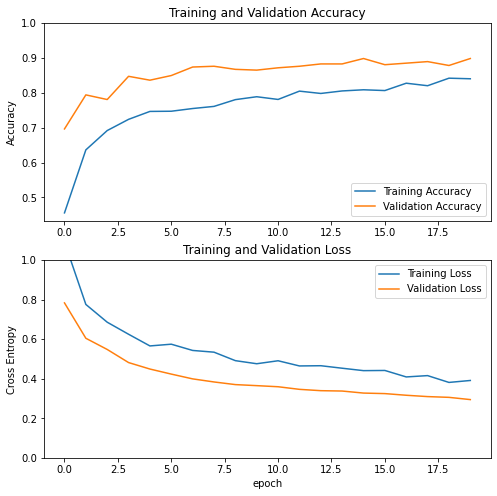

In [62]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Dari hasil evaluasi model setelah improvement dilakukan training sampai epoch 20. Nilai akurasi pada train adalah 0.84 sedangkan pada validation 0.89. Hal ini masih bisa diimprove lagi dengan memperbanyak nilai epochnya karena terlihat pada epoch terakhir model semakin mendekati fit. Namun karena keterbatasan waktu saya lakukan sampai nilai epoch 20 saja

In [72]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy :', accuracy)

15/15 [==============================] - 33s 2s/step - loss: 0.2945 - acc: 0.8980
Test accuracy : 0.898004412651062


# Model Saving

In [70]:
model.trainable = False

In [1]:
model.save("meat_classify.h5")

NameError: name 'model' is not defined

# 9. Model Inference

In [91]:
# Defining testing image
test_image_Fresh = '/Users/rezaismail/Hacktiv8/Phase 2/Assignment/M2/Meat Freshness.v1-new-dataset.multiclass/test/FRESH-536-_JPG.rf.0b008808df5376b8780a1cae10fcadbc.jpg'
test_image_Halffresh = '/Users/rezaismail/Hacktiv8/Phase 2/Assignment/M2/Meat Freshness.v1-new-dataset.multiclass/test/HALF-FRESH-288-_JPG.rf.d5b30738bb489d32e9531c34226cd0e4.jpg'
test_image_Spoiled = '/Users/rezaismail/Hacktiv8/Phase 2/Assignment/M2/Meat Freshness.v1-new-dataset.multiclass/test/SPOILED-198-_JPG.rf.064a8f5771cd410ba14dc7fea4f267fc.jpg'

# Image predict
img1 = keras.preprocessing.image.load_img(test_image_Fresh, target_size=(IMG_HEIGHT, IMG_WIDTH))
img2 = keras.preprocessing.image.load_img(test_image_Halffresh, target_size=(IMG_HEIGHT, IMG_WIDTH))
img3 = keras.preprocessing.image.load_img(test_image_Spoiled, target_size=(IMG_HEIGHT, IMG_WIDTH))


1/1 [==============================] - 0s 143ms/step


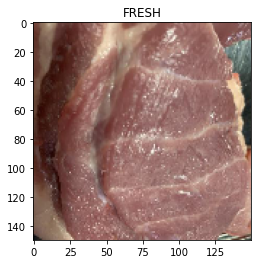

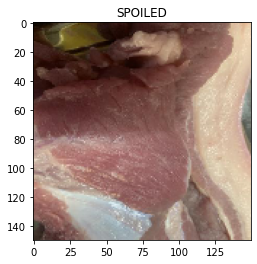

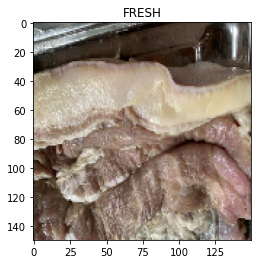

In [92]:
images = [img1,img2,img3]

for img in images:
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0]) 

  plt.figure()
  plt.imshow(img)
  plt.title(train_dataset.class_names[np.argmax(score)])

Pada model inference masih terdapat kesalahan dalam memprediksi gambar dengan klasifikasi Half-Fresh dan Spoiled. Model masih perlu improvement.

# 10. Conclusion

Dari keseluruhan proses, telah diakukan 2 kali modelling. Model awal sebelum dilakukan improvement menunjukan hasil model yang overfit. Selanjutnya dilakukan optimasi pada model dengan melakukan image augmentation pada train dataset kemudian digunakan transfer learning dengan base model Xception. Model tidak lagi overfit dan menunjukkan nilai akurasi train 0,84 dan akurasi validation 0.89.

Namun pada hasil inference model, terjadi kesalahan prediksi pada gambar dengan label Half-Fresh dan Spoiled. Maka proses pembuatan model ini perlu ditinjau ulang, karena kemungkinan ada kesalahan pada tahapan-tahapan preprocessing data. Selain itu jika masih ada waktu lebih bisa dilakukan penambahan nilai epoch yang lebih besar sampai terjadi callback pada proses training data.

